In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
import random
import os
import torchmetrics
import torch
from torch import nn
from torchvision import datasets
from pathlib import Path
from timeit import default_timer as timer
from tqdm.auto import tqdm
from mlxtend.plotting import plot_confusion_matrix
from typing import Tuple, Dict, List

torch.manual_seed(42)

torch.__version__

'2.0.1+cu118'

In [59]:
EPOCHS = 50
LR = 1e-3
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

BASELINE_CIFAR10_MODEL_NAME = "cifar_image_classification_baseline_cifar10.pth"
BASELINE_CIFAR100_MODEL_NAME = "cifar_image_classification_baseline_cifar100.pth"
CIFAR10_MODEL_NAME = "cifar_image_classification_cifar10.pth"
CIFAR100_MODEL_NAME = "cifar_image_classification_cifar100.pth"
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
BASELINE_CIFAR10_MODEL_SAVE_PATH = MODEL_PATH / BASELINE_CIFAR10_MODEL_NAME
BASELINE_CIFAR100_MODEL_SAVE_PATH = MODEL_PATH / BASELINE_CIFAR100_MODEL_NAME
CIFAR10_MODEL_SAVE_PATH = MODEL_PATH / CIFAR10_MODEL_NAME
CIFAR100_MODEL_SAVE_PATH = MODEL_PATH / CIFAR100_MODEL_NAME

device = "cuda" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

EPOCHS, LR, BATCH_SIZE, NUM_WORKERS, device

(50, 0.001, 32, 4, 'cuda')

In [60]:
def plot_results(results_1: List[float], results_2: List[float], label_1: str, label_2: str, title: str, xlabel: str = "Epochs") -> None:
  epochs = range(len(results_1))

  # Setup a plot 
  plt.figure(figsize=(12, 8))

  # Plot data
  plt.plot(epochs, results_1, label=label_1)
  plt.plot(epochs, results_2, label=label_2)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.legend();

In [61]:
def display_single_image(image: torch.Tensor, label: str) -> None:
  image = image / 2 + 0.5
  plt.imshow(image)
  plt.title(label)
  plt.axis(False);

In [62]:
def display_random_images(dataset: datasets, class_names: list) -> None:
  fig = plt.figure(figsize=(16, 16))
  rows, cols = 4, 4

  for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(dataset), size=[1]).item()
    img, label = dataset[random_idx]
    img = img / 2 + 0.5
    
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(class_names[label])
    plt.axis(False);

In [63]:
def train_step(
  model: nn.Module,
  dataloader: torch.utils.data.DataLoader,
  loss_fn: nn.Module,
  optimizer: torch.optim.Optimizer,
  accuracy_metric: torchmetrics.Accuracy,
  f1_metric: torchmetrics.F1Score,
  precision_metric: torchmetrics.Precision,
  recall_metric: torchmetrics.Recall,
  device: torch.device = 'cpu'
) -> Tuple[float, float, float, float, float]:
  # Setup initial values
  train_loss, train_acc, train_f1, train_precision, train_recall = 0, 0, 0, 0, 0

  # Model train mode
  model.train()
  for (inputs, labels) in dataloader:
    # Putting the data on the target device
    inputs, labels = inputs.to(device), labels.to(device)

    # Forward pass
    predictions = model(inputs)

    # Calculating the loss
    loss = loss_fn(predictions, labels)
    train_loss += loss

    # Calculating the metrics
    accuracy_metric(predictions, labels)
    f1_metric(predictions, labels)
    precision_metric(predictions, labels)
    recall_metric(predictions, labels)

    # Optimizer zero grad, backpropagation, optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # Calculating the training loss
  train_loss /= len(dataloader)

  # Calculating the other metrics
  train_acc = accuracy_metric.compute()
  train_f1 = f1_metric.compute()
  train_precision = precision_metric.compute()
  train_recall = recall_metric.compute()

  # Print the loss and metrics
  print(
    f"Train loss: {train_loss} | "
    f"Train accuracy: {train_acc} | "
    f"Train F1: {train_f1} | "
    f"Train precision: {train_precision} | "
    f"Train recall: {train_recall}"
  )

  # Reset the metrics for new data
  accuracy_metric.reset()
  f1_metric.reset()
  precision_metric.reset()
  recall_metric.reset()

  return train_loss.item(), train_acc.item(), train_f1.item(), train_precision.item(), train_recall.item()

In [64]:
def test_step(
  model: nn.Module,
  dataloader: torch.utils.data.DataLoader,
  loss_fn: nn.Module,
  accuracy_metric: torchmetrics.Accuracy,
  f1_metric: torchmetrics.F1Score,
  precision_metric: torchmetrics.Precision,
  recall_metric: torchmetrics.Recall,
  device: torch.device = 'cpu'
) -> Tuple[float, float, float, float, float]:
  # Setup initial values
  test_loss, test_acc, test_f1, test_precision, test_recall = 0, 0, 0, 0, 0

  # Model eval mode, and inference context manager
  model.eval()
  with torch.inference_mode():
    for (inputs, labels) in dataloader:
      # Putting the data on the target device
      inputs, labels = inputs.to(device), labels.to(device)

      # Forward pass
      predictions = model(inputs)

      # Calculating the loss
      test_loss += loss_fn(predictions, labels)

      # Calculating the metrics
      accuracy_metric(predictions, labels)
      f1_metric(predictions, labels)
      precision_metric(predictions, labels)
      recall_metric(predictions, labels)

    # Calculating the test loss
    test_loss /= len(dataloader)

    # Calculating the other metrics
    test_acc = accuracy_metric.compute()
    test_f1 = f1_metric.compute()
    test_precision = precision_metric.compute()
    test_recall = recall_metric.compute()

    # Print the loss and metrics
    print(
      f"Test loss: {test_loss} | "
      f"Test accuracy: {test_acc} | "
      f"Test F1: {test_f1} | "
      f"Test precision: {test_precision} | "
      f"Test recall: {test_recall}"
    )

    # Reset the metrics for new data
    accuracy_metric.reset()
    f1_metric.reset()
    precision_metric.reset()
    recall_metric.reset()

  return test_loss.item(), test_acc.item(), test_f1.item(), test_precision.item(), test_recall.item()

In [65]:
def eval_model(
  model: nn.Module, 
  dataloader: torch.utils.data.DataLoader, 
  loss_fn: nn.Module, 
  class_amount: int, 
  train_time: int = None, 
  device: torch.device = 'cpu', 
  dataset_name: str = ""
) -> Dict:

  # Setup the metrics
  accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=class_amount).to(device)
  f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=class_amount).to(device)
  precision_metric = torchmetrics.Precision(task="multiclass", average="macro", num_classes=class_amount).to(device)
  recall_metric = torchmetrics.Recall(task="multiclass", average="macro", num_classes=class_amount).to(device)
  
  # Get metrics
  loss, acc, f1, precision, recall = test_step(model, dataloader, loss_fn, accuracy_metric, f1_metric, precision_metric, recall_metric, device)

  # Get results dictionary
  return {
    "model_name": dataset_name + " " + model.__class__.__name__,
    "model_loss": loss,
    "model_accuracy": acc,
    "model_f1": f1,
    "model_precision": precision,
    "model_recall": recall,
    "model_train_time": train_time if train_time != None else "no data"
  }

In [66]:
def train_model(
  model: nn.Module, 
  train_dataloader: torch.utils.data.DataLoader, 
  test_dataloader: torch.utils.data.DataLoader, 
  loss_fn: nn.Module, 
  optimizer: torch.optim.Optimizer, 
  num_classes: int, 
  device: torch.device = 'cpu', 
  dataset: str = ""
) -> Dict:
  # Setup the training metrics
  train_accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)
  train_f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=num_classes).to(device)
  train_precision_metric = torchmetrics.Precision(task="multiclass", average="macro", num_classes=num_classes).to(device)
  train_recall_metric = torchmetrics.Recall(task="multiclass", average="macro", num_classes=num_classes).to(device)

  # Setup the testing metrics
  test_accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)
  test_f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=num_classes).to(device)
  test_precision_metric = torchmetrics.Precision(task="multiclass", average="macro", num_classes=num_classes).to(device)
  test_recall_metric = torchmetrics.Recall(task="multiclass", average="macro", num_classes=num_classes).to(device)

  # Initialize the results dictionary
  results = {
    "train_loss": [],
    "train_acc": [],
    "train_f1": [],
    "train_precision": [],
    "train_recall": [],
    "test_loss": [],
    "test_acc": [],
    "test_f1": [],
    "test_precision": [],
    "test_recall": []
  }

  # Initialize the start time
  start_time = timer()

  # Iterate the epochs
  for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch + 1}\n")

    # Perform the train and test steps
    train_loss, train_acc, train_f1, train_prec, train_recall = train_step(model, train_dataloader, loss_fn, optimizer, train_accuracy_metric, train_f1_metric, train_precision_metric, train_recall_metric, device)
    test_loss, test_acc, test_f1, test_prec, test_recall = test_step(model, test_dataloader, loss_fn, test_accuracy_metric, test_f1_metric, test_precision_metric, test_recall_metric, device)

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["train_f1"].append(train_f1)
    results["train_precision"].append(train_prec)
    results["train_recall"].append(train_recall)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    results["test_f1"].append(test_f1)
    results["test_precision"].append(test_prec)
    results["test_recall"].append(test_recall)

    print("----------------------------")

  # Initialize the end time
  end_time = timer()

  # Print the total training time
  print(f"\nTotal training time: {end_time - start_time}s")

  return results

In [67]:
def plot_evaluations(dataframe: pd.DataFrame, plot_train_time: bool = False) -> None:
  nrows = 6 if plot_train_time else 5
  
  _, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(15, 25))

  dataframe.set_index("model_name")["model_loss"].plot(kind="barh", ax=axes[0])
  axes[0].set_xlabel("Loss")
  axes[0].set_ylabel("Model")

  dataframe.set_index("model_name")["model_accuracy"].mul(100).plot(kind="barh", ax=axes[1])
  axes[1].set_xlabel("Accuracy (%)")
  axes[1].set_ylabel("Model")
  
  dataframe.set_index("model_name")["model_f1"].mul(100).plot(kind="barh", ax=axes[2])
  axes[2].set_xlabel("F1 (%)")
  axes[2].set_ylabel("Model")

  dataframe.set_index("model_name")["model_precision"].mul(100).plot(kind="barh", ax=axes[3])
  axes[3].set_xlabel("Precision (%)")
  axes[3].set_ylabel("Model")

  dataframe.set_index("model_name")["model_recall"].mul(100).plot(kind="barh", ax=axes[4])
  axes[4].set_xlabel("Recall (%)")
  axes[4].set_ylabel("Model")

  if plot_train_time:
    dataframe.set_index("model_name")["model_train_time"].plot(kind="barh", ax=axes[5])
    axes[5].set_xlabel("Train time (s)")
    axes[5].set_ylabel("Model")

  plt.subplots_adjust(hspace=1) 

  plt.show();

In [68]:
def make_random_predictions(model: nn.Module, data: torch.utils.data.Dataset, device: torch.device = device):
  test_samples = []
  test_labels = []
  for sample, label in random.sample(list(data), k=9):
    sample = sample / 2 + 0.5
    test_samples.append(sample)
    test_labels.append(label)

  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in test_samples:
      sample = torch.unsqueeze(sample, dim=0).to(device)

      pred_logit = model(sample)

      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      pred_probs.append(pred_prob.cpu())
          
  return torch.softmax(torch.stack(pred_probs), dim=1).argmax(dim=1), test_samples, test_labels

In [69]:
def make_predictions(model: nn.Module, dataloader: torch.utils.data.DataLoader):
  y_preds = []

  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(dataloader, desc="Making predictions"):
      X, y = X.to(device), y.to(device)
      
      y_logit = model(X)
      y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
      y_preds.append(y_pred.cpu())

  return torch.cat(y_preds)

In [70]:
def plot_predictions(samples: list, class_names: list, pred_classes: list, test_labels: list) -> None: 
  plt.figure(figsize=(9, 9))
  nrows = 3
  ncols = 3
  for i, sample in enumerate(samples):
    plt.subplot(nrows, ncols, i+1)

    plt.imshow(sample.permute(1, 2, 0))

    pred_label = class_names[pred_classes[i]]

    truth_label = class_names[test_labels[i]] 

    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    
    if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g")
    else:
      plt.title(title_text, fontsize=10, c="r")
      
    plt.axis(False);

In [71]:
def display_confusion_matrix(class_names: np.array, y_pred: torch.Tensor, targets: torch.Tensor) -> None:
  confmat = torchmetrics.ConfusionMatrix(num_classes=len(class_names), task='multiclass')
  confmat_tensor = confmat(preds=y_pred, target=targets)

  _ = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), 
    class_names=class_names, 
    figsize=(10, 7)
  ); 

In [72]:
cifar_10_train_dataset = datasets.CIFAR10(
  root="data",
  train=True,
  download=True,
  transform=transform,
)

cifar_10_test_dataset = datasets.CIFAR10(
  root="data",
  train=False,
  download=True,
  transform=transform,
)

cifar_100_train_dataset = datasets.CIFAR100(
  root="data",
  train=True,
  download=True,
  transform=transform,
)

cifar_100_test_dataset = datasets.CIFAR100(
  root="data",
  train=False,
  download=True,
  transform=transform,
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [73]:
temp_image, temp_label = cifar_10_train_dataset[0]

temp_label, temp_image.shape

(6, torch.Size([3, 32, 32]))

In [74]:
len(cifar_10_train_dataset), len(cifar_10_test_dataset), len(cifar_100_train_dataset), len(cifar_100_test_dataset)

(50000, 10000, 50000, 10000)

In [75]:
cifar_10_class_names = cifar_10_train_dataset.classes
cifar_100_class_names = cifar_100_train_dataset.classes

cifar_10_class_names, cifar_100_class_names[:10]

(['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 ['apple',
  'aquarium_fish',
  'baby',
  'bear',
  'beaver',
  'bed',
  'bee',
  'beetle',
  'bicycle',
  'bottle'])

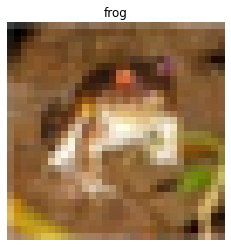

In [76]:
display_single_image(temp_image.permute(1, 2, 0), cifar_10_class_names[temp_label])

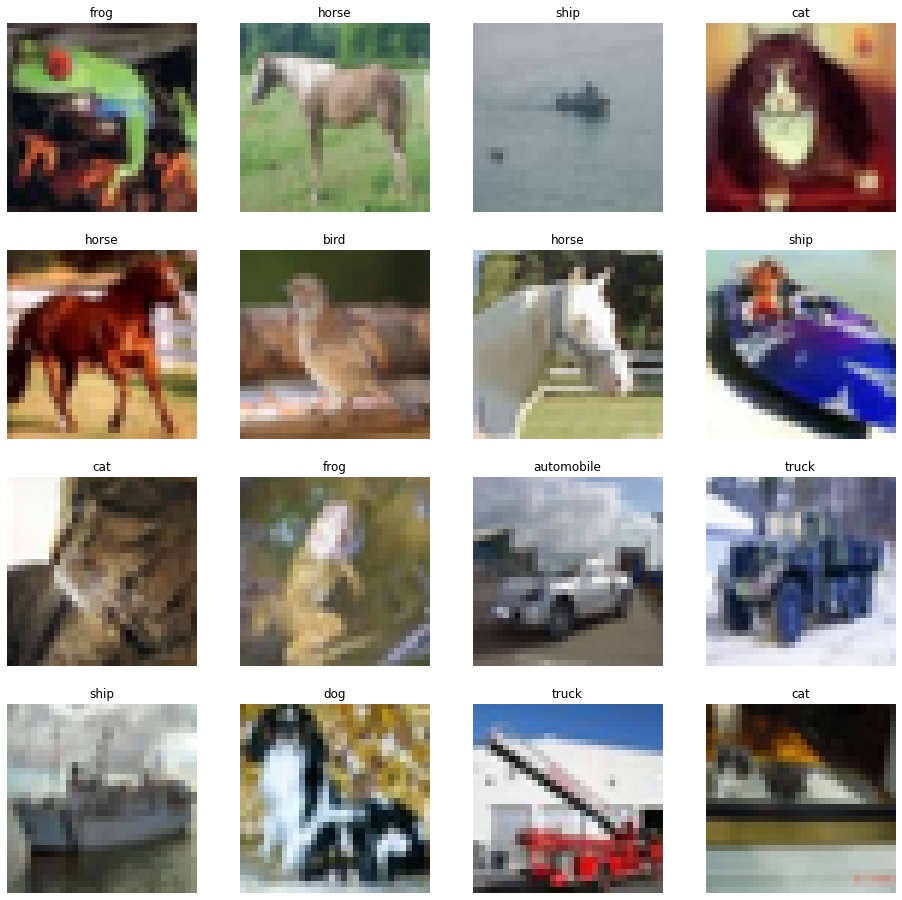

In [77]:
display_random_images(cifar_10_train_dataset, cifar_10_class_names)

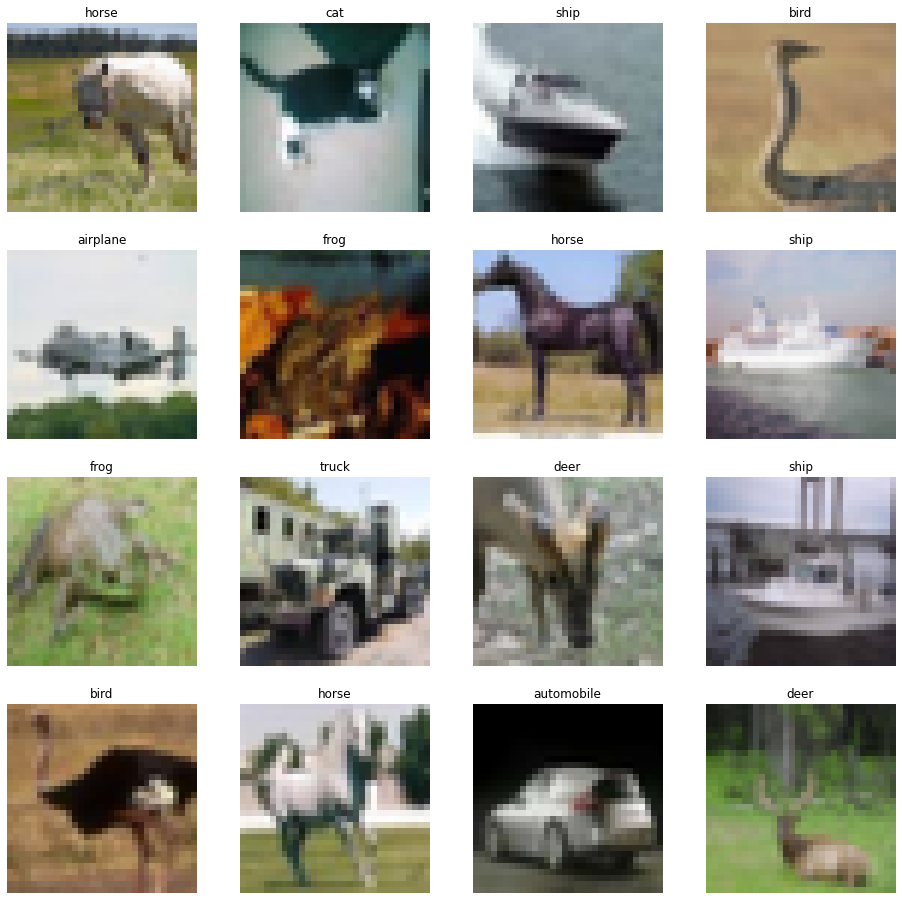

In [78]:
display_random_images(cifar_10_test_dataset, cifar_10_class_names)

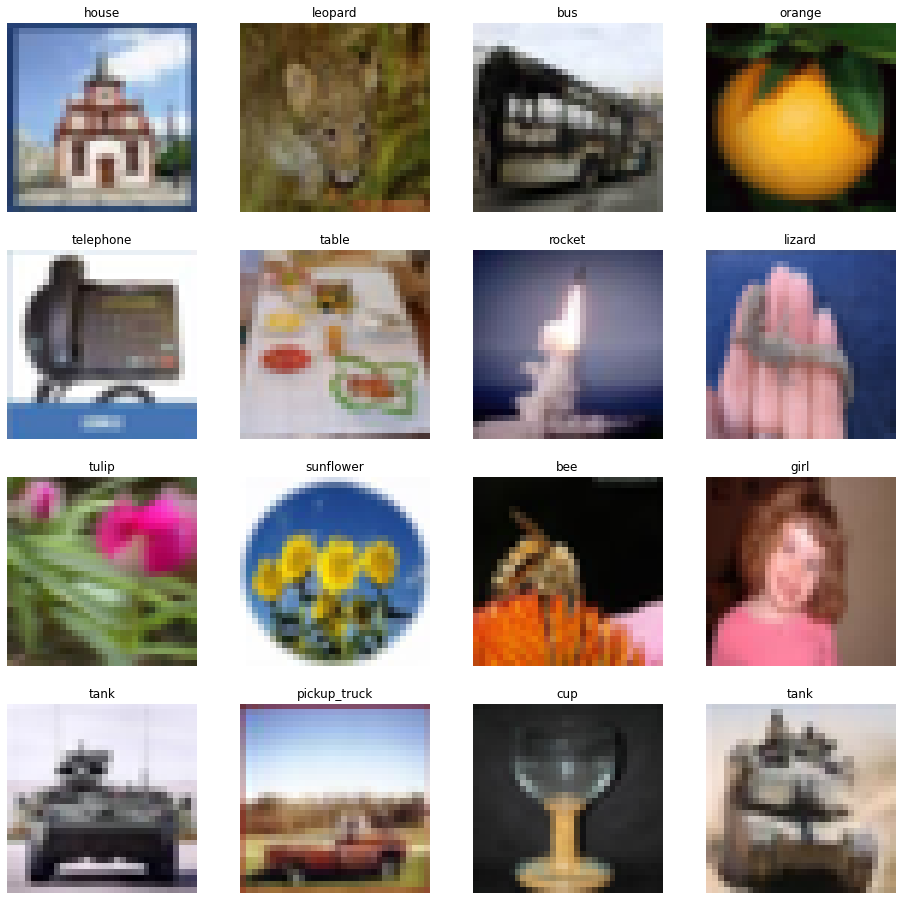

In [79]:
display_random_images(cifar_100_train_dataset, cifar_100_class_names)

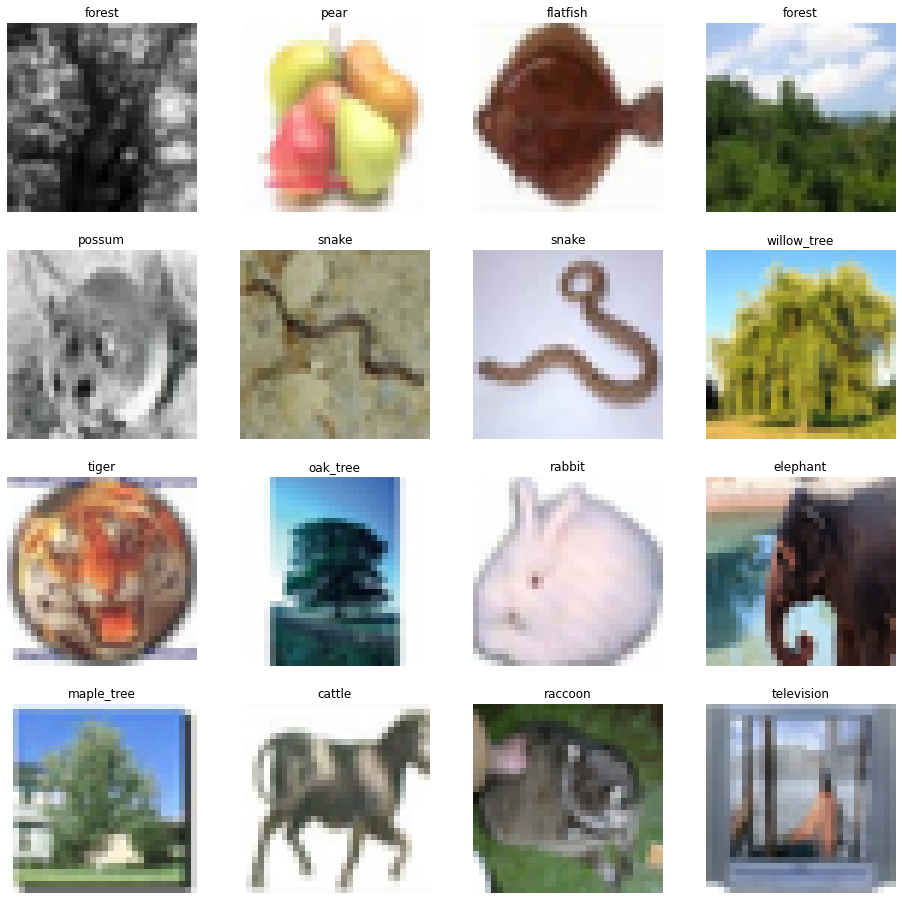

In [80]:
display_random_images(cifar_100_test_dataset, cifar_100_class_names)

In [81]:
cifar_10_train_dataloader = torch.utils.data.DataLoader(
  cifar_10_train_dataset,
  batch_size=BATCH_SIZE,
  shuffle=True,
  num_workers=NUM_WORKERS
)

cifar_10_test_dataloader = torch.utils.data.DataLoader(
  cifar_10_test_dataset,
  batch_size=BATCH_SIZE,
  shuffle=False,
  num_workers=NUM_WORKERS
)

cifar_100_train_dataloader = torch.utils.data.DataLoader(
  cifar_100_train_dataset,
  batch_size=BATCH_SIZE,
  shuffle=True,
  num_workers=NUM_WORKERS
)

cifar_100_test_dataloader = torch.utils.data.DataLoader(
  cifar_100_test_dataset,
  batch_size=BATCH_SIZE,
  shuffle=False,
  num_workers=NUM_WORKERS
)

print(f"CIFAR10 train dataloader: {len(cifar_10_train_dataloader)} batches of {BATCH_SIZE}")
print(f"CIFAR10 test dataloader: {len(cifar_10_test_dataloader)} batches of {BATCH_SIZE}")
print(f"CIFAR100 train dataloader: {len(cifar_100_train_dataloader)} batches of {BATCH_SIZE}")
print(f"CIFAR100 test dataloader: {len(cifar_100_test_dataloader)} batches of {BATCH_SIZE}")

CIFAR10 train dataloader: 1563 batches of 32
CIFAR10 test dataloader: 313 batches of 32
CIFAR100 train dataloader: 1563 batches of 32
CIFAR100 test dataloader: 313 batches of 32


In [82]:
class ClassificationBaselineModel(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=input_shape, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features= 2 * hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=2 * hidden_units, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=output_shape),
      nn.ReLU(),
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_stack(x)

In [83]:
layer = nn.Flatten()
layer(temp_image).shape, np.prod(np.array(temp_image.shape))

(torch.Size([3, 1024]), 3072)

In [84]:
cifar_10_baseline_model = ClassificationBaselineModel(input_shape=np.prod(np.array(temp_image.shape)), hidden_units=16, output_shape=len(cifar_10_class_names))

cifar_10_baseline_model = cifar_10_baseline_model.to(device)

In [85]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=cifar_10_baseline_model.parameters(), lr=LR)

In [86]:
cifar_10_baseline_model_results = train_model(cifar_10_baseline_model, cifar_10_train_dataloader, cifar_10_test_dataloader, loss_fn, optimizer, len(cifar_10_class_names), device, "CIFAR10")
evaluated_cifar_10_baseline_model = eval_model(cifar_10_baseline_model, cifar_10_test_dataloader, loss_fn, len(cifar_10_class_names), device=device, dataset_name="CIFAR 10")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1

Train loss: 1.8779557943344116 | Train accuracy: 0.3387199938297272 | Train F1: 0.3387199938297272 | Train precision: 0.3021823763847351 | Train recall: 0.33872002363204956
Test loss: 1.767980933189392 | Test accuracy: 0.3797000050544739 | Test F1: 0.3797000050544739 | Test precision: 0.34072500467300415 | Test recall: 0.3797000050544739
----------------------------
Epoch: 2

Train loss: 1.7333006858825684 | Train accuracy: 0.3991999924182892 | Train F1: 0.3991999924182892 | Train precision: 0.41584253311157227 | Train recall: 0.3992000222206116
Test loss: 1.7171885967254639 | Test accuracy: 0.4032999873161316 | Test F1: 0.4032999873161316 | Test precision: 0.44048774242401123 | Test recall: 0.4032999873161316
----------------------------
Epoch: 3

Train loss: 1.6839709281921387 | Train accuracy: 0.41940000653266907 | Train F1: 0.41940000653266907 | Train precision: 0.44494765996932983 | Train recall: 0.41940000653266907
Test loss: 1.690797209739685 | Test accuracy: 0.4212000

Making predictions:   0%|          | 0/313 [00:12<?, ?it/s]

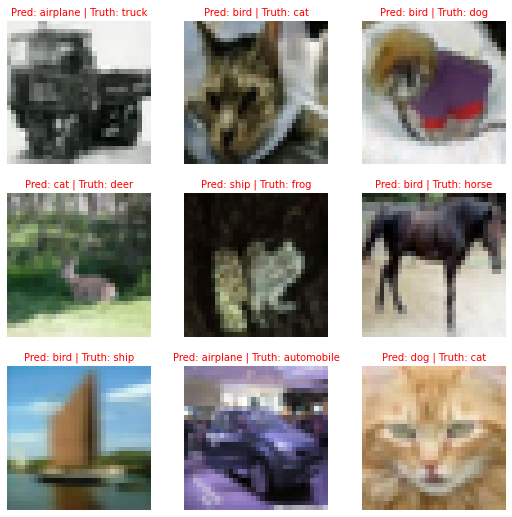

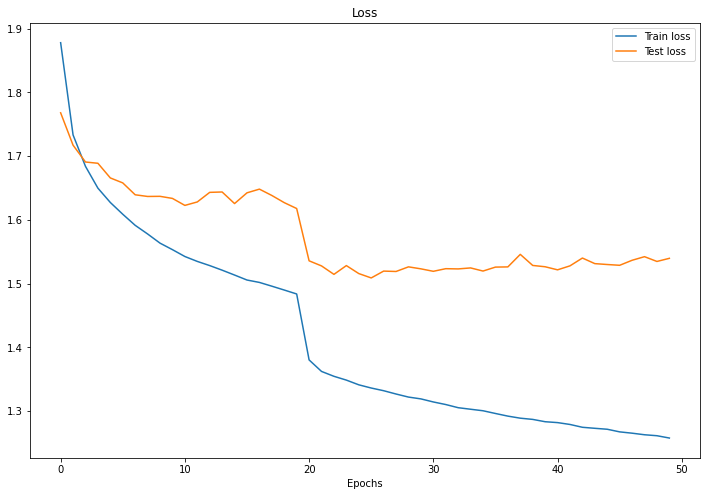

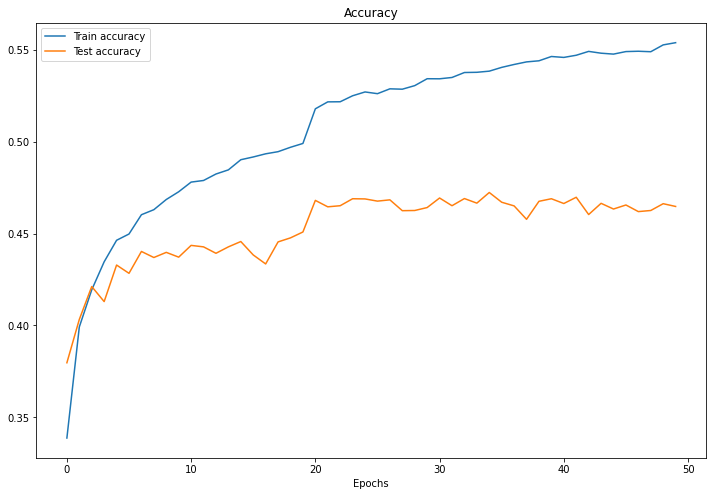

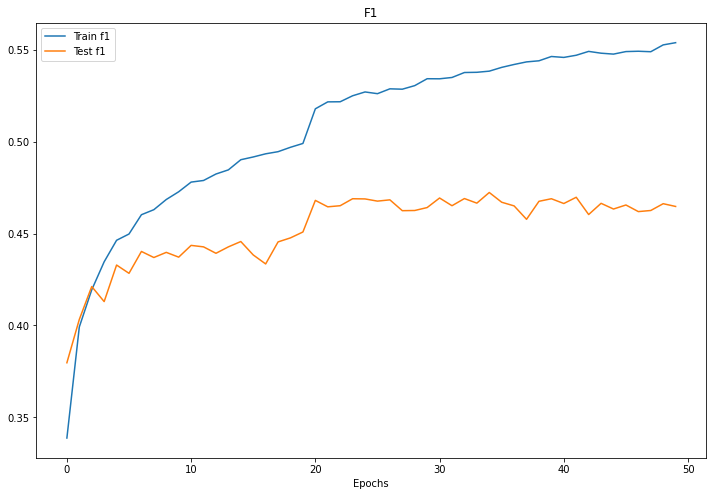

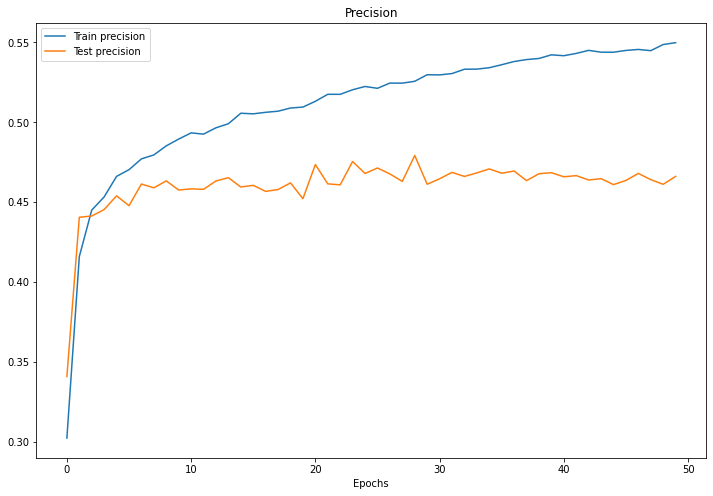

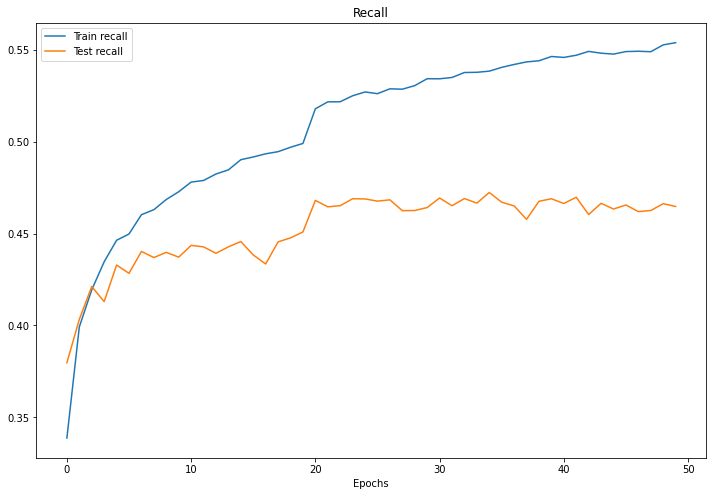

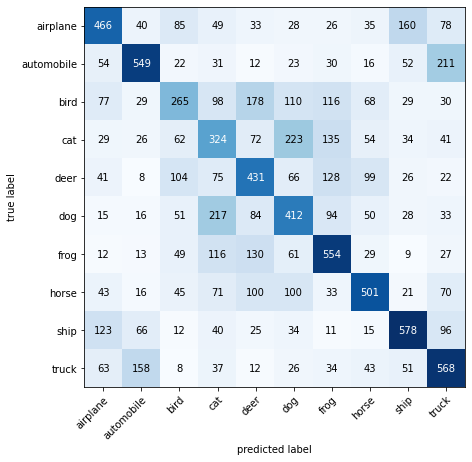

In [87]:
cifar_10_baseline_pred_classes, samples, labels = make_random_predictions(cifar_10_baseline_model, cifar_10_test_dataset, device)

plot_predictions(samples, cifar_10_class_names, cifar_10_baseline_pred_classes, labels)
plot_results(cifar_10_baseline_model_results["train_loss"], cifar_10_baseline_model_results["test_loss"], "Train loss", "Test loss", "Loss")
plot_results(cifar_10_baseline_model_results["train_acc"], cifar_10_baseline_model_results["test_acc"], "Train accuracy", "Test accuracy", "Accuracy")
plot_results(cifar_10_baseline_model_results["train_f1"], cifar_10_baseline_model_results["test_f1"], "Train f1", "Test f1", "F1")
plot_results(cifar_10_baseline_model_results["train_precision"], cifar_10_baseline_model_results["test_precision"], "Train precision", "Test precision", "Precision")
plot_results(cifar_10_baseline_model_results["train_recall"], cifar_10_baseline_model_results["test_recall"], "Train recall", "Test recall", "Recall")

display_confusion_matrix(cifar_10_class_names, make_predictions(cifar_10_baseline_model, cifar_10_test_dataloader), torch.tensor(cifar_10_test_dataset.targets))

In [88]:
class TinyVGGModel(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0)),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units, out_channels=2 * hidden_units, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0)),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2, 2))
    )
    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=2 * hidden_units, out_channels=hidden_units, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0)),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0)),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2, 2))
    )
    self.classifier_layer = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=400, out_features=output_shape)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    return self.classifier_layer(x)

In [89]:
cifar_10_model = TinyVGGModel(input_shape=3, hidden_units=16, output_shape=len(cifar_10_class_names))

cifar_10_model = cifar_10_model.to(device)

In [90]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=cifar_10_model.parameters(), lr=LR)

In [91]:
cifar_10_model_results = train_model(cifar_10_model, cifar_10_train_dataloader, cifar_10_test_dataloader, loss_fn, optimizer, len(cifar_10_class_names), device, "CIFAR10")
evaluated_cifar_10_model = eval_model(cifar_10_model, cifar_10_test_dataloader, loss_fn, len(cifar_10_class_names), device=device, dataset_name="CIFAR 10")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1

Train loss: 1.5926927328109741 | Train accuracy: 0.4216200113296509 | Train F1: 0.4216200113296509 | Train precision: 0.41428932547569275 | Train recall: 0.4216199815273285
Test loss: 1.381838321685791 | Test accuracy: 0.4952999949455261 | Test F1: 0.4952999949455261 | Test precision: 0.5179159641265869 | Test recall: 0.4952999949455261
----------------------------
Epoch: 2

Train loss: 1.2826756238937378 | Train accuracy: 0.542460024356842 | Train F1: 0.542460024356842 | Train precision: 0.536628007888794 | Train recall: 0.542460024356842
Test loss: 1.195011019706726 | Test accuracy: 0.5735999941825867 | Test F1: 0.5735999941825867 | Test precision: 0.5787553787231445 | Test recall: 0.5735999941825867
----------------------------
Epoch: 3

Train loss: 1.1655057668685913 | Train accuracy: 0.5871000289916992 | Train F1: 0.5871000289916992 | Train precision: 0.582541823387146 | Train recall: 0.5870999693870544
Test loss: 1.118250846862793 | Test accuracy: 0.5982000231742859 | T

Making predictions:   0%|          | 0/313 [00:12<?, ?it/s]

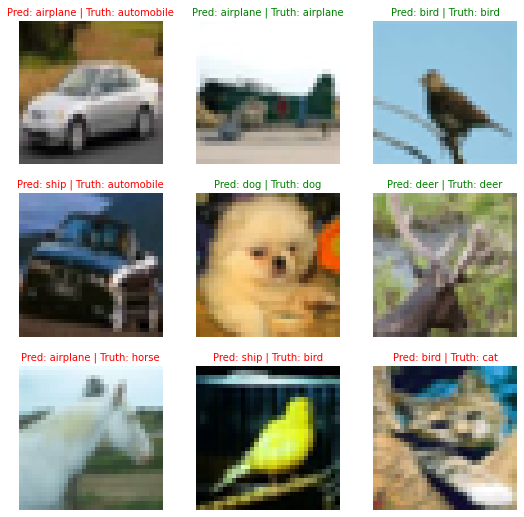

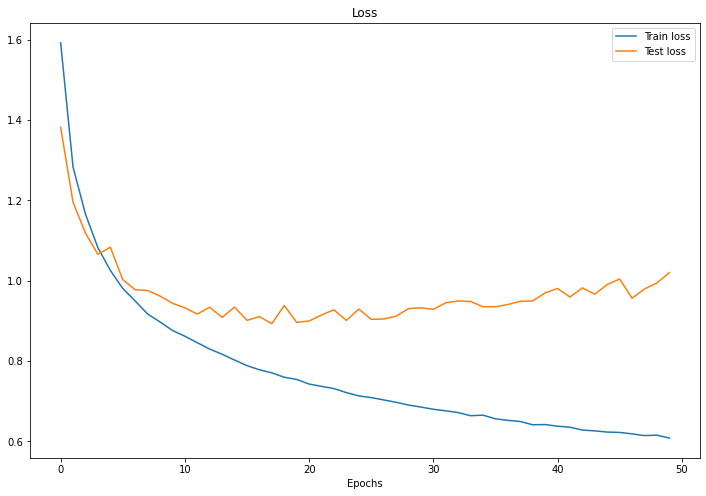

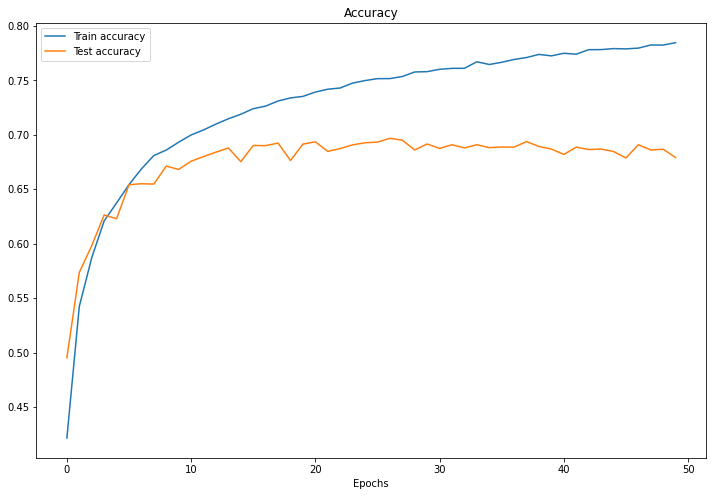

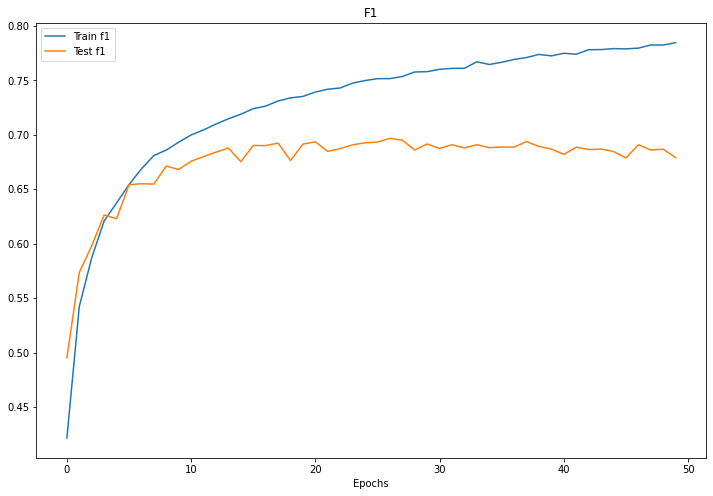

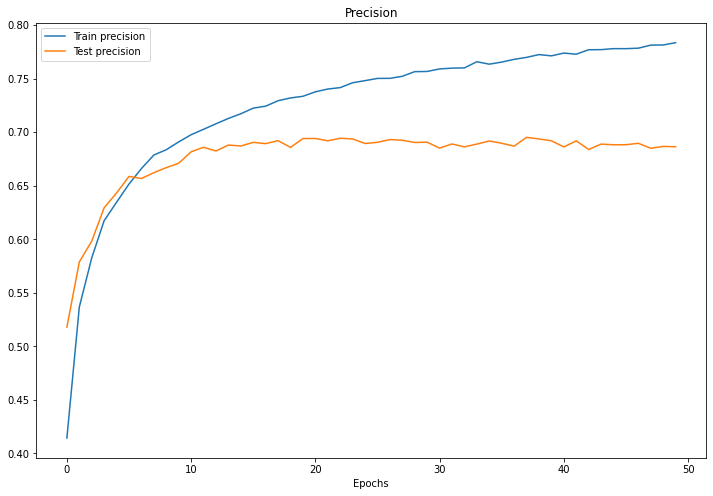

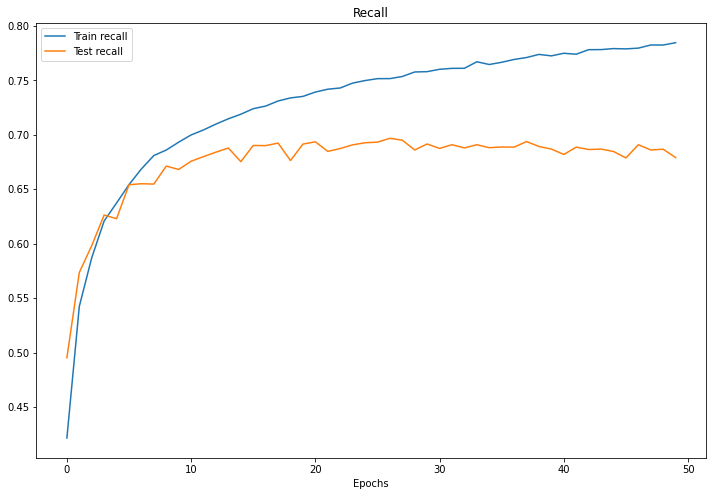

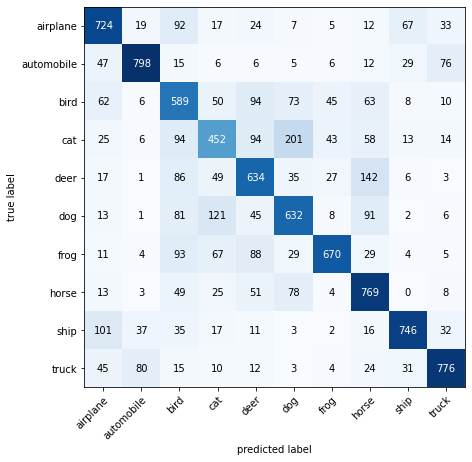

In [92]:
cifar_10_model_pred_classes, samples, labels = make_random_predictions(cifar_10_model, cifar_10_test_dataset, device)

plot_predictions(samples, cifar_10_class_names, cifar_10_model_pred_classes, labels)
plot_results(cifar_10_model_results["train_loss"], cifar_10_model_results["test_loss"], "Train loss", "Test loss", "Loss")
plot_results(cifar_10_model_results["train_acc"], cifar_10_model_results["test_acc"], "Train accuracy", "Test accuracy", "Accuracy")
plot_results(cifar_10_model_results["train_f1"], cifar_10_model_results["test_f1"], "Train f1", "Test f1", "F1")
plot_results(cifar_10_model_results["train_precision"], cifar_10_model_results["test_precision"], "Train precision", "Test precision", "Precision")
plot_results(cifar_10_model_results["train_recall"], cifar_10_model_results["test_recall"], "Train recall", "Test recall", "Recall")

display_confusion_matrix(cifar_10_class_names, make_predictions(cifar_10_model, cifar_10_test_dataloader), torch.tensor(cifar_10_test_dataset.targets))

In [93]:
cifar_100_baseline_model = ClassificationBaselineModel(input_shape=np.prod(np.array(temp_image.shape)), hidden_units=16, output_shape=len(cifar_100_class_names))

cifar_100_baseline_model = cifar_100_baseline_model.to(device)

In [94]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=cifar_100_baseline_model.parameters(), lr=LR)

In [95]:
cifar_100_baseline_model_results = train_model(cifar_100_baseline_model, cifar_100_train_dataloader, cifar_100_test_dataloader, loss_fn, optimizer, len(cifar_100_class_names), device, "CIFAR100")
evaluated_cifar_100_baseline_model = eval_model(cifar_100_baseline_model, cifar_100_test_dataloader, loss_fn, len(cifar_100_class_names), device=device, dataset_name="CIFAR 100")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1

Train loss: 4.422119140625 | Train accuracy: 0.0560000017285347 | Train F1: 0.0560000017285347 | Train precision: 0.024876270443201065 | Train recall: 0.0560000017285347
Test loss: 4.345666408538818 | Test accuracy: 0.0771000012755394 | Test F1: 0.0771000012755394 | Test precision: 0.031046666204929352 | Test recall: 0.0771000012755394
----------------------------
Epoch: 2

Train loss: 4.292552471160889 | Train accuracy: 0.09374000132083893 | Train F1: 0.09374000132083893 | Train precision: 0.042557209730148315 | Train recall: 0.09373999387025833
Test loss: 4.282454013824463 | Test accuracy: 0.1005999967455864 | Test F1: 0.1005999967455864 | Test precision: 0.05123705416917801 | Test recall: 0.1005999967455864
----------------------------
Epoch: 3

Train loss: 4.22743558883667 | Train accuracy: 0.10927999764680862 | Train F1: 0.10927999764680862 | Train precision: 0.05091547966003418 | Train recall: 0.10928000509738922
Test loss: 4.2484612464904785 | Test accuracy: 0.10450000

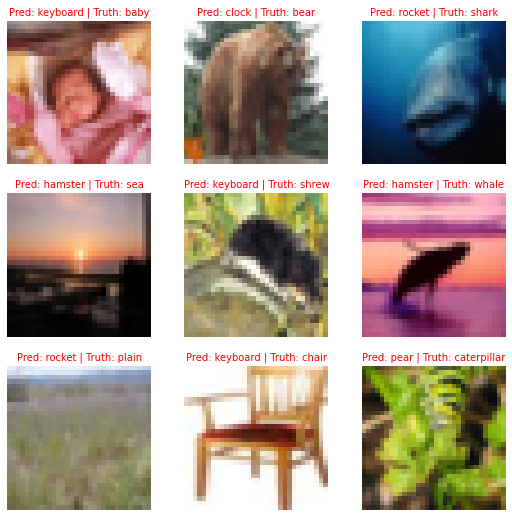

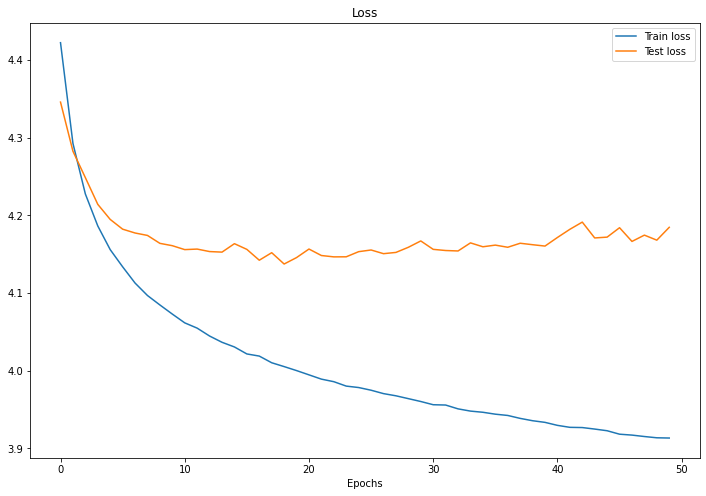

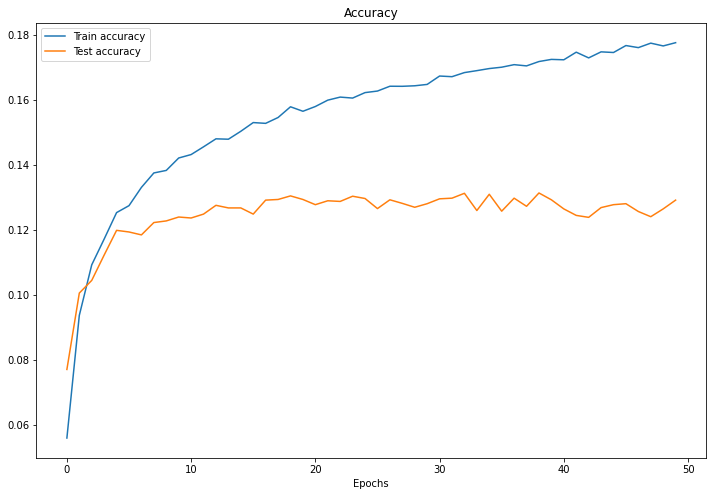

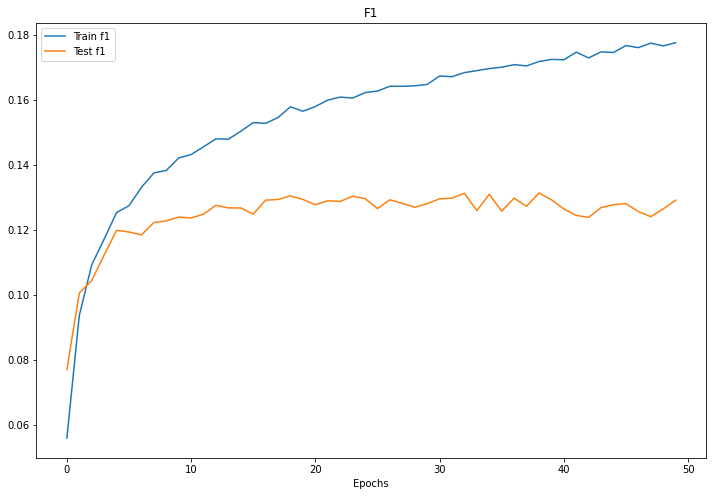

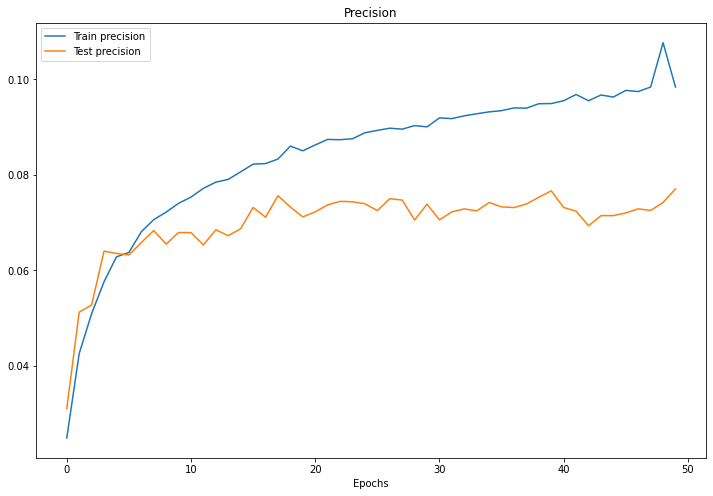

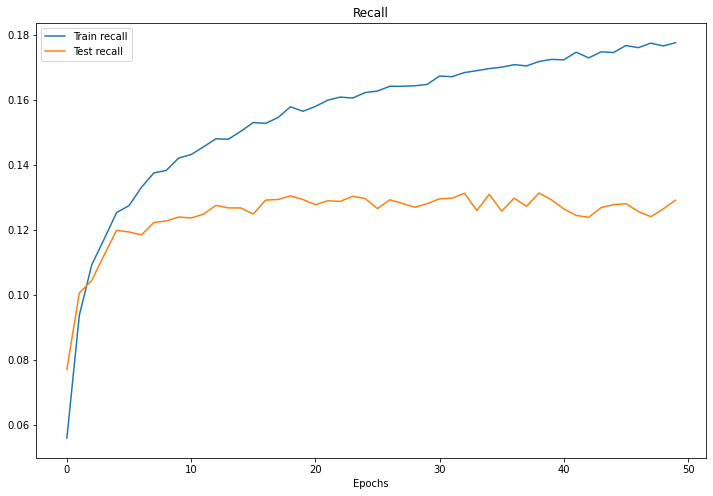

In [96]:
cifar_100_baseline_pred_classes, samples, labels = make_random_predictions(cifar_100_baseline_model, cifar_100_test_dataset, device)

plot_predictions(samples, cifar_100_class_names, cifar_100_baseline_pred_classes, labels)
plot_results(cifar_100_baseline_model_results["train_loss"], cifar_100_baseline_model_results["test_loss"], "Train loss", "Test loss", "Loss")
plot_results(cifar_100_baseline_model_results["train_acc"], cifar_100_baseline_model_results["test_acc"], "Train accuracy", "Test accuracy", "Accuracy")
plot_results(cifar_100_baseline_model_results["train_f1"], cifar_100_baseline_model_results["test_f1"], "Train f1", "Test f1", "F1")
plot_results(cifar_100_baseline_model_results["train_precision"], cifar_100_baseline_model_results["test_precision"], "Train precision", "Test precision", "Precision")
plot_results(cifar_100_baseline_model_results["train_recall"], cifar_100_baseline_model_results["test_recall"], "Train recall", "Test recall", "Recall")

In [97]:
cifar_100_model = TinyVGGModel(input_shape=3, hidden_units=16, output_shape=len(cifar_100_class_names))

cifar_100_model = cifar_100_model.to(device)

In [98]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=cifar_100_model.parameters(), lr=LR)

In [99]:
cifar_100_model_results = train_model(cifar_100_model, cifar_100_train_dataloader, cifar_100_test_dataloader, loss_fn, optimizer, len(cifar_100_class_names), device, "CIFAR100")
evaluated_cifar_100_model = eval_model(cifar_100_model, cifar_100_test_dataloader, loss_fn, len(cifar_100_class_names), device=device, dataset_name="CIFAR 100")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1

Train loss: 3.777472496032715 | Train accuracy: 0.13612000644207 | Train F1: 0.13612000644207 | Train precision: 0.12385979294776917 | Train recall: 0.1361199915409088
Test loss: 3.3570139408111572 | Test accuracy: 0.21209999918937683 | Test F1: 0.21209999918937683 | Test precision: 0.2303410768508911 | Test recall: 0.21209999918937683
----------------------------
Epoch: 2

Train loss: 3.202285051345825 | Train accuracy: 0.23717999458312988 | Train F1: 0.23717999458312988 | Train precision: 0.22061949968338013 | Train recall: 0.23718000948429108
Test loss: 3.1400740146636963 | Test accuracy: 0.25949999690055847 | Test F1: 0.25949999690055847 | Test precision: 0.2705194354057312 | Test recall: 0.25949999690055847
----------------------------
Epoch: 3

Train loss: 2.9934885501861572 | Train accuracy: 0.2759400010108948 | Train F1: 0.2759400010108948 | Train precision: 0.259762704372406 | Train recall: 0.2759400010108948
Test loss: 3.049450635910034 | Test accuracy: 0.2684000134

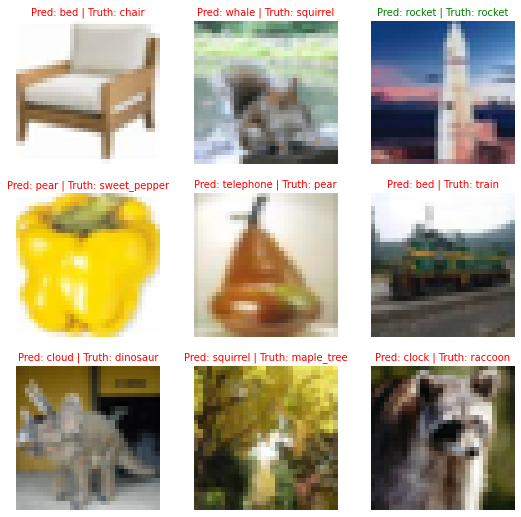

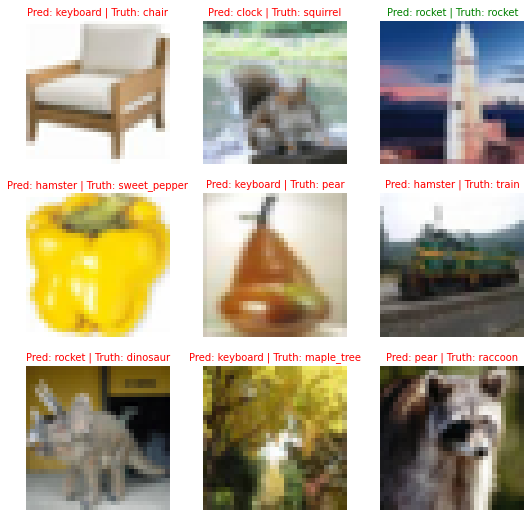

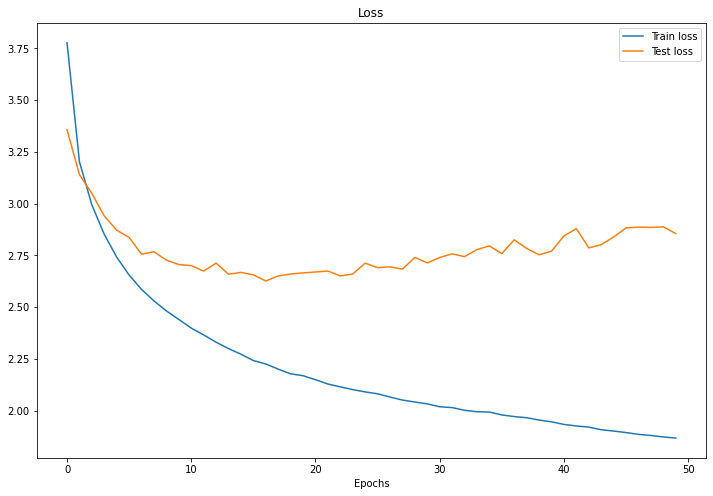

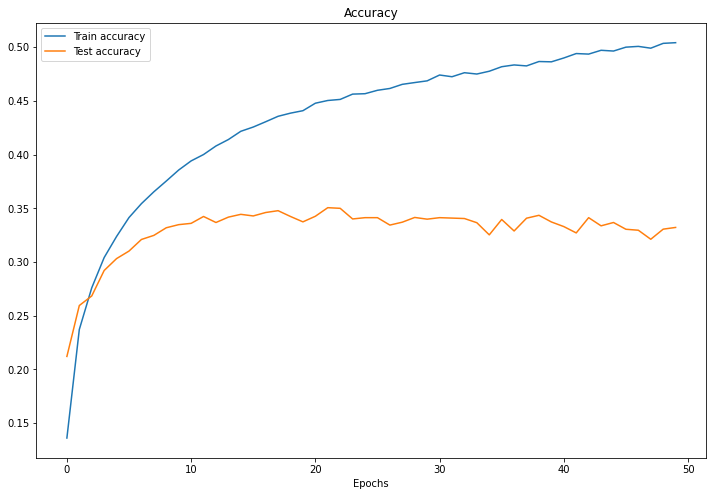

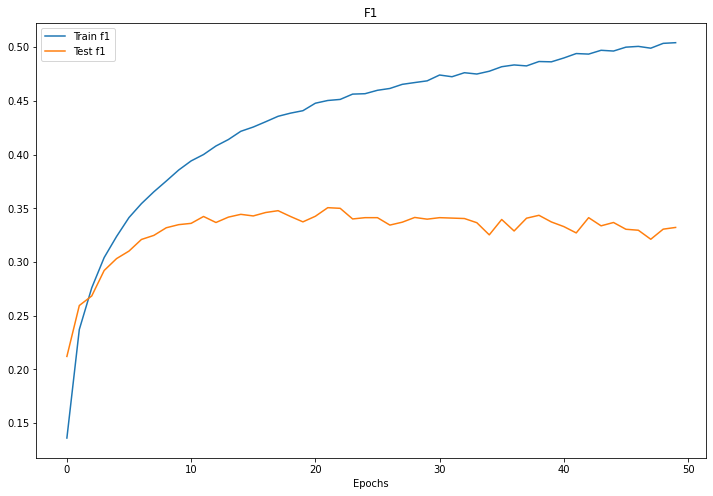

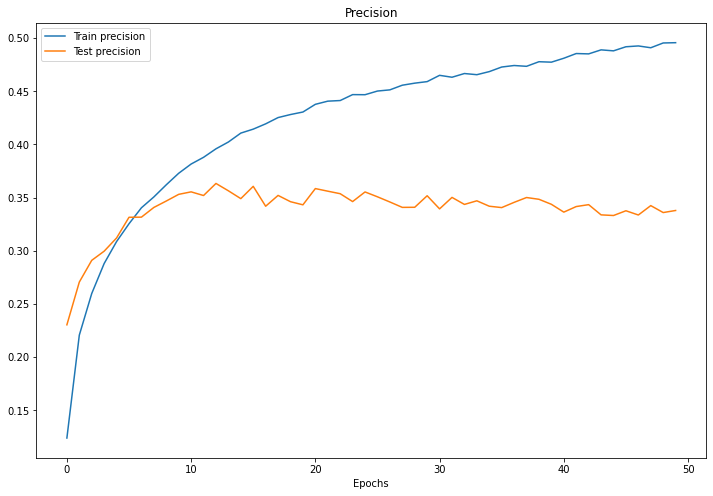

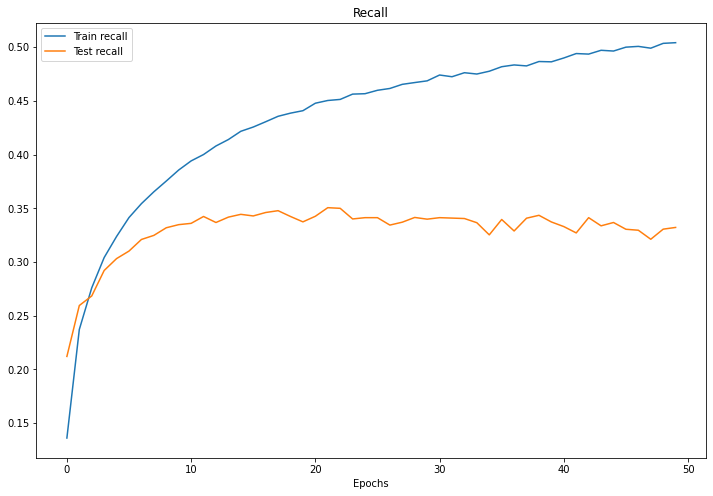

In [100]:
cifar_100_model_pred_classes, samples, labels = make_random_predictions(cifar_100_model, cifar_100_test_dataset, device)

plot_predictions(samples, cifar_100_class_names, cifar_100_model_pred_classes, labels)
plot_predictions(samples, cifar_100_class_names, cifar_100_baseline_pred_classes, labels)
plot_results(cifar_100_model_results["train_loss"], cifar_100_model_results["test_loss"], "Train loss", "Test loss", "Loss")
plot_results(cifar_100_model_results["train_acc"], cifar_100_model_results["test_acc"], "Train accuracy", "Test accuracy", "Accuracy")
plot_results(cifar_100_model_results["train_f1"], cifar_100_model_results["test_f1"], "Train f1", "Test f1", "F1")
plot_results(cifar_100_model_results["train_precision"], cifar_100_model_results["test_precision"], "Train precision", "Test precision", "Precision")
plot_results(cifar_100_model_results["train_recall"], cifar_100_model_results["test_recall"], "Train recall", "Test recall", "Recall")

In [101]:
results_table = pd.DataFrame([evaluated_cifar_10_baseline_model, evaluated_cifar_10_model, evaluated_cifar_100_baseline_model, evaluated_cifar_100_model])
results_table

,model_name,model_loss,model_accuracy,model_f1,model_precision,model_recall,model_train_time
0,CIFAR 10 ClassificationBaselineModel,1.539716,0.4648,0.4648,0.466051,0.4648,no data
1,CIFAR 10 TinyVGGModel,1.020140,0.6790,0.6790,0.686407,0.6790,no data
2,CIFAR 100 ClassificationBaselineModel,4.184524,0.1292,0.1292,0.077056,0.1292,no data
3,CIFAR 100 TinyVGGModel,2.855382,0.3322,0.3322,0.337849,0.3322,no data


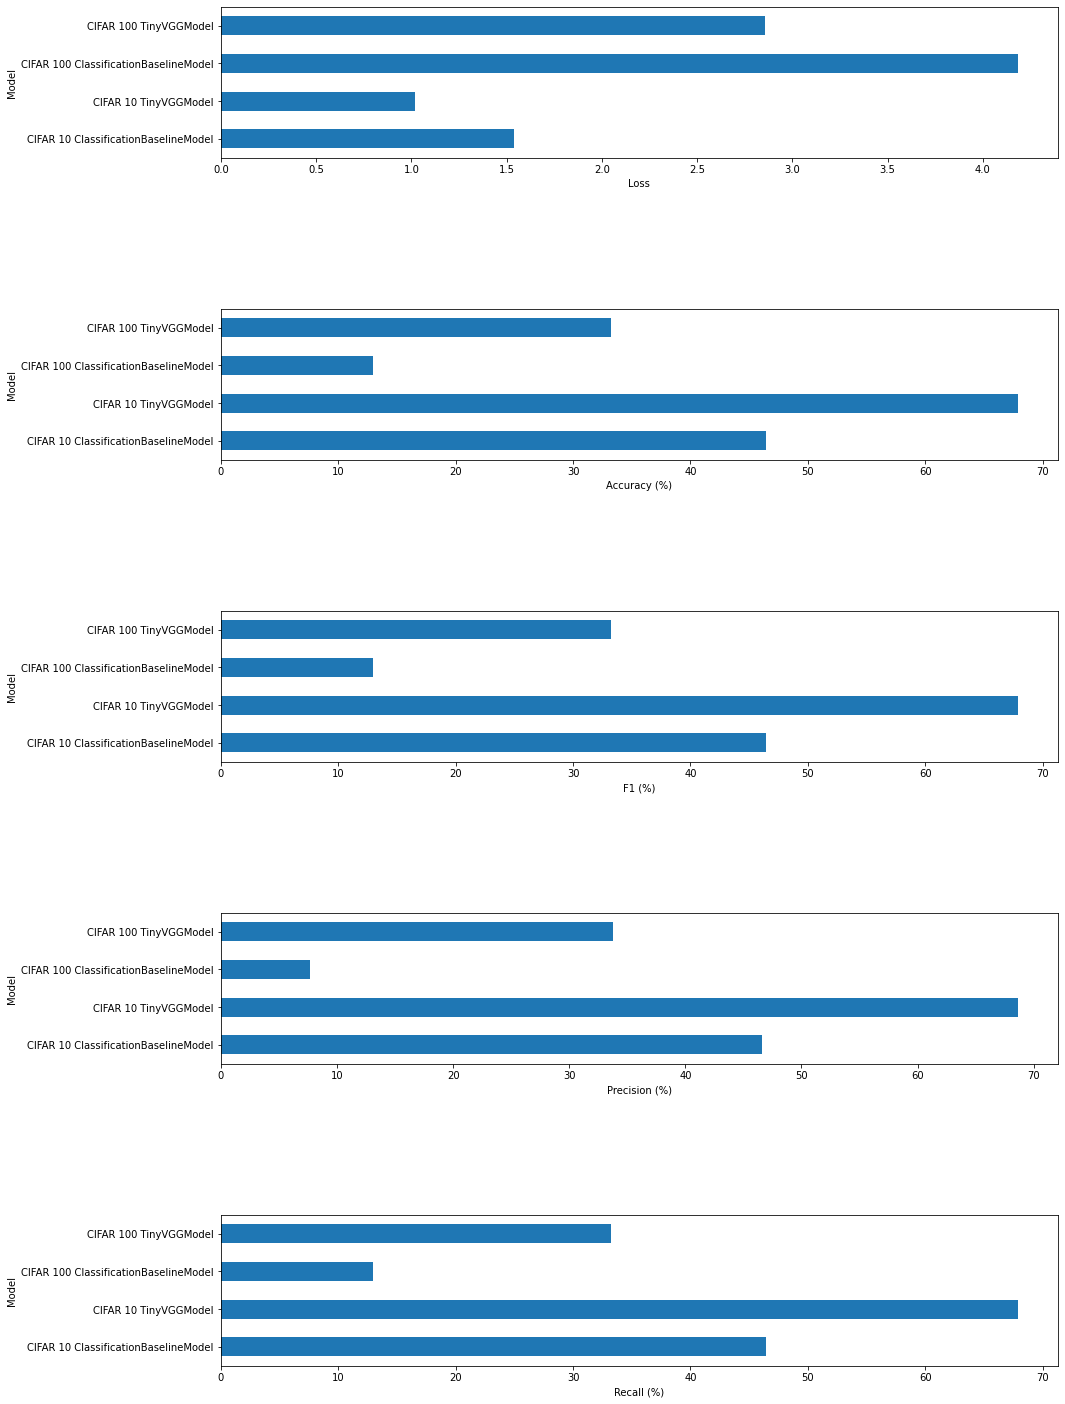

In [102]:
plot_evaluations(results_table)

In [104]:
models = [cifar_10_baseline_model, cifar_100_baseline_model, cifar_10_model, cifar_100_model]
paths = [BASELINE_CIFAR10_MODEL_SAVE_PATH, BASELINE_CIFAR100_MODEL_SAVE_PATH, CIFAR10_MODEL_SAVE_PATH, CIFAR100_MODEL_SAVE_PATH]

for i in range(len(models)):
  print(f"Saving model {models[i].__class__.__name__} to: {paths[i]}...")
  torch.save(obj=cifar_100_model.state_dict(), f=paths[i])

Saving model ClassificationBaselineModel to: models\cifar_image_classification_baseline_cifar10.pth...
Saving model ClassificationBaselineModel to: models\cifar_image_classification_baseline_cifar100.pth...
Saving model TinyVGGModel to: models\cifar_image_classification_cifar10.pth...
Saving model TinyVGGModel to: models\cifar_image_classification_cifar100.pth...
